# Estimation of Heterogeneous Treatment Effects

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

In [3]:
from econml.dml import CausalForestDML as CausalForest

## Part I - Introduction

### Project Overview

In this project, I am going to estimate the Heterogeneous Treatment Effects (HTEs) of a large-scale randomized experiment in primary school students' academic learning (measured as standardized test scores), using Random Causal Forest (RCF) methods. The treatment provides a carefully chosen in-class library, a resource-type nudge intended to promote students' independent reading. 

I will build and interpret Random Causal Forest, a popular Machine Learning (ML) algorithm for Causal Inference (CI). I show below the codes I use to build random forests, predict the full distribution of individual TEs (as well as average treatment effects), and identify important correlates.

It is primarily Python-based and uses the EconML libraries developed by the ALICE team at Microsoft Research.

### Problem Background

Previous studies have shown null average treatment effects on academic learning of this type of interventions. I am interested in understanding if specific student subgroups benefit more (or less) from the treatment. The question is important to learn since it can provide insights on improving treatment targeting and treatment design.

To examine the heterogeneous treatment effects, a traditional way that economists use is to run regressions with interaction terms or separately estimate the treatment effects for subgroups. This approach comes with two main challenges. One is that the traditional heterogeneous analysis imposes functional form restrictions; another is related to the curse of dimensionality, where OLS can be infeasible if we have many covariates to consider.

Machine learning methods, however, may be an attractive alternative, given its flexibility and predictive accuracy. Here, I showcase the application of random causal forests (Wager and Athey, 2018), a data-driven approach, to investigate the role of students' characteristics in determining program effects.

### Dataset Information

The dataset used in the analysis below has been prepared from raw data collected by a research team at Stanford. It is presented in a .xlsx file, with each row representing a student and each column containing various features related to the student. These features include students' baseline characteristics, treatment status, and endline test scores.

## Part II - Statistical Analysis

### 1. Import in data

The dataset has 5231 student records and 79 features. I later group the features into three groups: 

    y - the outcomes (i.e., endline subject test scores)
    z - the treatment (i.e, whether provided in-class library)
    x - the covariates (mostly student characteristics such as age, gender)

In [5]:
read2 = pd.read_csv('/Users/jitingjiang/OneDrive/Career/Courses/projects/project_readii_rcf/jiangxi_2015_2016_2017_g4_reshape.csv')
read2

,stu_code,sch_code2015,stu_female2015,stu_byear2015,stu_f_board2015,stu_sl_never2015,stu_cl_yes2015,stu_cl_never2015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,...,std_chi2017,treat2017,insurvey2017,hh_p_edu_high2017,hh_p_work_prof2017,hh_lb2017,hh_nofridge2017,stu_schrres2017,stu_SLR_std2017,stu_SCR_std2017
0,10114101,1011,1,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,0.0,0.0,NaN,0.0,-0.021379,-1.163930
1,10114102,1011,1,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,1.0,0.0,NaN,0.0,0.883299,0.378313
2,10114103,1011,1,2005.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,0.280180,-0.547033
3,10114104,1011,1,2004.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,1.184858,0.378313
4,10114105,1011,0,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,0.280180,-0.238584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,31934124,3193,0,2005.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-0.016498,0,1,0.0,0.0,0.0,NaN,1.0,1.486417,2.229004
5227,31934125,3193,1,2004.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,0,1,0.0,0.0,1.0,NaN,1.0,-0.322938,-0.855481
5228,31934126,3193,1,2005.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,0,1,0.0,0.0,0.0,NaN,1.0,-0.322938,0.069864
5229,31934127,3193,0,2005.0,0.0,1.0,1.0,1.0,0.0,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# define the variables
# the y
y1 = read2['std_read2016'] 
y2 = read2['std_chi2016']
y3 = read2['std_math2016']

# the z
z = read2['treat2015'] # treat assignment

# the x
x0 = read2[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015' #  Student reading habits (cont.)
           ]] 
x1 = read2['std_read2015']
x2 = read2['std_chi2015']
x3 = read2['std_math2015']

### 2. Clean the data

I then generate three separate samples, each containing unique subject test scores. The collected subject tests include reading, math, and language. Every students in the sample is expected to take the reading test while they either take math tests or chinese language tests (but not both) in survey waves. 

Next, I remove rows with missing values in the three datasets. After addressing the missing values, the reading, math, and language datasets consist of 4288, 2144, and 2132 observations, respectively.

#### 2.1 The Reading Dataset (df_read)

In [7]:
df_read = pd.concat([y1, z, x0, x1], axis=1)
df_read

,std_read2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_read2015
0,-0.599193,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.666053
1,0.086907,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.126665
2,1.459106,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
3,1.184666,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
4,-0.324753,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.736356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.498567,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.520601
5227,-2.108613,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.744829
5228,0.224127,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-1.313318
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.097563


In [8]:
df_read = df_read.dropna()
df_read

,std_read2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_read2015
0,-0.599193,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.666053
1,0.086907,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.126665
2,1.459106,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
3,1.184666,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
4,-0.324753,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.736356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,-1.834173,0,2005.0,0,0.0,0.0,1.0,0.0,0.0,1,...,-1.389269,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.636951
5225,0.635787,0,2005.0,1,0.0,0.0,1.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.059989
5226,0.498567,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.520601
5227,-2.108613,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.744829


#### 2.2 The Math Dataset (df_math)

In [9]:
df_math = pd.concat([y3, z, x0, x3], axis=1)
df_math

,std_math2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_math2015
0,-0.120764,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.461401
1,-1.244299,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.587293
2,0.066492,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.415086
3,1.002771,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.790383
4,1.939051,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.227437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,NaN,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN
5227,-1.244299,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.774942
5228,0.066492,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-0.649049
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.962590


In [10]:
df_math = df_math.dropna()
df_math

,std_math2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_math2015
0,-0.120764,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.461401
1,-1.244299,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.587293
2,0.066492,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.415086
3,1.002771,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.790383
4,1.939051,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.227437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5217,-1.618811,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.836698
5219,0.253748,0,2004.0,1,0.0,0.0,0.0,0.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-0.836698
5221,1.002771,0,2005.0,0,0.0,0.0,0.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.476843
5227,-1.244299,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.774942


#### 2.3 The Chinese Language Dataset (df_chi)

In [11]:
df_chi = pd.concat([y2, z, x0, x2], axis=1)
df_chi

,std_chi2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_chi2015
0,NaN,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
1,NaN,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
2,NaN,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
3,NaN,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
4,NaN,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.995239,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.767136
5227,NaN,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN
5228,NaN,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN


In [12]:
df_chi = df_chi.dropna()
df_chi

,std_chi2016,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_chi2015
5,0.773116,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.086325,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.040582
6,0.328869,0,2003.0,0,0.0,0.0,0.0,1.0,1.0,0,...,1.034281,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.714242
7,-1.225993,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,0,...,0.428394,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.129301
8,0.550993,0,2004.0,0,0.0,0.0,0.0,0.0,1.0,0,...,-1.692212,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.572629
9,0.995239,0,2004.0,0,0.0,0.0,1.0,0.0,0.0,0,...,-1.086325,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.363277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222,-1.003870,0,2004.0,0,0.0,0.0,0.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.104676
5223,-1.003870,0,2005.0,1,0.0,0.0,1.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.455641
5224,-0.337500,0,2005.0,0,0.0,0.0,1.0,0.0,0.0,1,...,-1.389269,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.859500
5225,-0.337500,0,2005.0,1,0.0,0.0,1.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.235089


### 3. Apply Random Causal Forest for HTE

Now it is ready to apply the Random Causal Forest method to assess the heterogeneous treatment effects. Here is a step-by-step description.

**First**, there are two identification assumptions for RCF to work. 

    Assumption 1: Conditional independence (or selection on observables)
    Assumption 2: Overlap
    
I argue the two assumptions hold in my case. For assumption 1, the "gold standard", namely randomized controlled trial, ensures the treatment is random and not correlated with students' characteristics. For assumption 2, the covariates I consider are quite general, such as gender, age, baseline test scores, with high probability of appearing in both treated and control groups.

**Second**, for each of the three datasets with unique subject test socres, I set the parameters of the causal forest and fit the model using CausalForestDML package from the double machine learning (dml) module of EconML.

Specifically, the splitting criterion is set to "het" for heterogeneous treatment effect, the number of trees is set to 500. The honest approach is also enabled by default. Random seed is set to 42 for replication purposes.

**Third**, after fitting the model, I first use it to (1) predict the individual Conditional Average Treatment Effects (CATEs) along with their corresponding confidence intervals. These predictions allow me to (2) visualize the distribution of the effects and confidence intervals (CI). Additionally, I (3) calculate the feature importance scores to identify the most influential feature for prediction. I further (4) analyze the relationship between the effects and the most important feature for each of the three datasets.

#### 3.1 For Reading Test Scores

#### 3.1.0 Fit the RCF Model

In [13]:
# define the variables
y = df_read['std_read2016'] 

z = df_read['treat2015'] # treat assignment

x = df_read[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_read2015']] 

In [14]:
# Instantiate the Causal Forest
rcf_read = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_read.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

#### 3.1.1 Predict Individual CATEs (along with CI)

In [15]:
# Calculate the predicted effects (for each observation)
insamplefx_read = rcf_read.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_read, ub_read = rcf_read.effect_interval(x, alpha=0.05)

In [16]:
# Merge CATEs into the original dataframe
df_read['effects'] = insamplefx_read
df_read['effects_lb'] = lb_read
df_read['effects_ub'] = ub_read


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_read[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.595708,-1.019800,-0.171616
1,-0.563390,-0.906325,-0.220454
2,-0.508736,-0.738676,-0.278796
3,-0.490655,-0.912380,-0.068930
4,-0.460664,-0.700445,-0.220883
...,...,...,...
4283,0.251830,-0.022709,0.526369
4284,0.261066,0.011600,0.510532
4285,0.272594,-0.016388,0.561576
4286,0.296645,-0.199109,0.792399


#### 3.1.2 Visualize the Distribution of Predicted CATEs

I present two visualizations below. The first figure focuses on the spread of effect estimates with average effects (and its CI) overlaid. The second figure displays the confidence intervals for all the effect estimates arranged from the smallest to the largest.

Based on these plots, we can draw several interpretations: 
   * The average treatent effect is close to zero.
   * The estimated treatment effects vary from below -0.4 to above 0.2. 
   * Most of the treatment effects are not statistically different from zero.
   * There seems no clear evidence of treatment effect heterogeneity for most of the observations, except for the least affected ones.

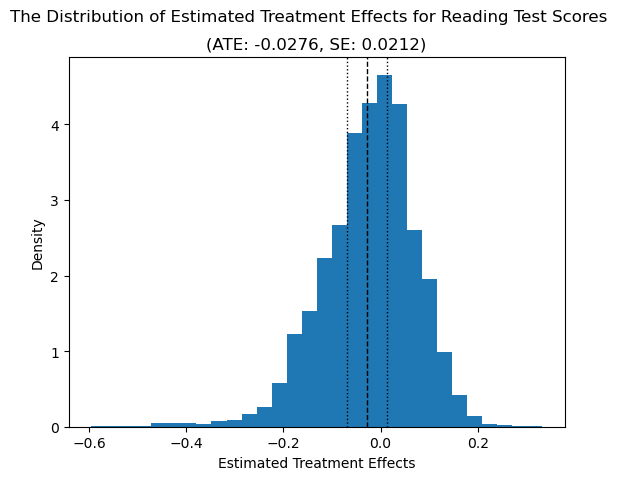

In [18]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_read, bins=30, density=True)
plt.axvline(rcf_read.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_read.ate_+1.96*rcf_read.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_read.ate_-1.96*rcf_read.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Reading Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_read.ate_[0], rcf_read.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

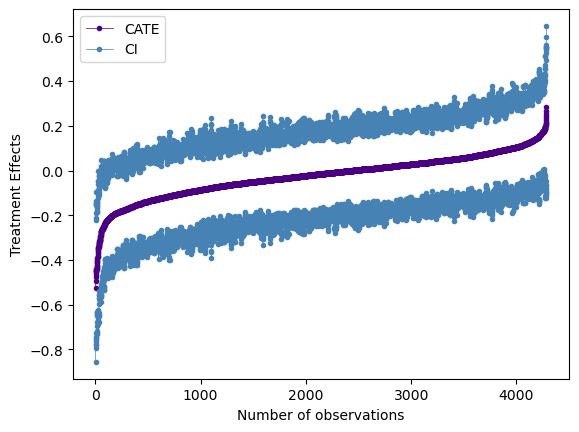

In [19]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

#### 3.1.3 Calculate Feature Importance

I then move onto calculate the feature importance, which indicates how often a variable is used in a tree split and reflects its contribution to the prediction. The table below presents the results, listing the features in descending order of importance. 

According to the feature importance rankings, the baseline standardized student liking reading (SLR) scores had the highest importance, followed by the baseline standardized reading test scores. This suggests the need to assess CATE in subgroups, such as students who enjoy reading versus those who do not.

In [20]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_read2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_read.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
stu_SLR_std2015,0.254798
std_read2015,0.171941
stu_SCR_std2015,0.140470
stu_rfrd_rborrow2015,0.047099
stu_byear2015,0.046174
stu_female2015,0.036641
stu_rfrd_rtogether2015,0.031872
stu_home_rtime_a302015,0.030664
stu_cl_never2015,0.027062
hh_lb2015,0.027037


#### 3.1.4 Visualize The Relationship Between Predicted CATEs and the Most Important Feature 

Now we know the feature importance, but it remains unclear how the most important feature relates to the predicted CATEs. One approach to gaining insight is by creating a scatter plot that displays indivisual values. The x-axis shows different values of the most important feature, while the y-axis represents the predicted effects. Additionally, smooth, local polynomial functions are fitted to the data to faciliate the interpretation.

The plot below indicates a nonlinear and potential negative relationship between the baseline student like reading scores and the predicted treatment effects. Students who have a lower liking for reading at baseline (i.e., baseline student like reading scores less than 0) may be more likely to experience negative effects from the treatment. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

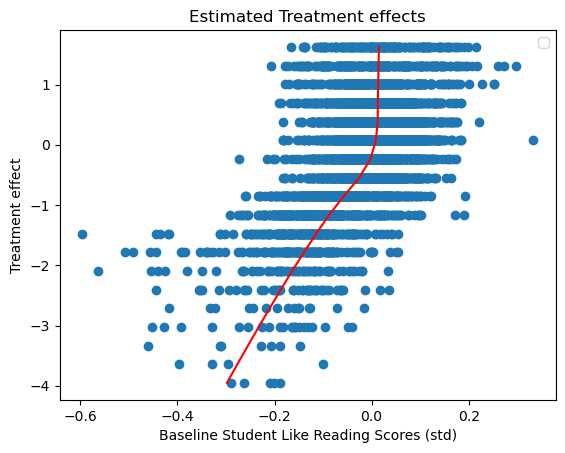

In [21]:
lowess = sm.nonparametric.lowess(df_read['effects'], df_read['stu_SLR_std2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_read['effects'], df_read['stu_SLR_std2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Student Like Reading Scores (std)")
plt.ylabel("Treatment effect")

Next, I repeated the analysis using the math dataset (df_math) and language dataset (df_chi). Here are the findings from the two datasets.

The key findings from both the math dataset and the language dataset are quite similar. Specifically, the average treatment effects are both found to be close to zero. However, the standard errors are larger compared to the reading datasets, which can be attributed to the reduced sample size. The most important feature in predicting the effects is baseline standardized math or language test scores, though no interesting heterogeneous patterns were observed in relation to this feature.

#### 3.2 For Math Test Scores

In [22]:
# define the variables
y = df_math['std_math2016'] 

z = df_math['treat2015'] # treat assignment

x = df_math[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
         'std_math2015']] 

In [23]:
# Instantiate the Causal Forest
rcf_math = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_math.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

In [24]:
# Calculate the predicted effects (for each observation)
insamplefx_math = rcf_math.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_math, ub_math = rcf_math.effect_interval(x, alpha=0.05)

In [25]:
# Merge CATEs into the original dataframe
df_math['effects'] = insamplefx_math
df_math['effects_lb'] = lb_math
df_math['effects_ub'] = ub_math


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_math[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.313852,-0.764308,0.136605
1,-0.299413,-0.611820,0.012994
2,-0.293681,-0.514278,-0.073084
3,-0.248148,-0.787497,0.291202
4,-0.240548,-0.563317,0.082221
...,...,...,...
2139,0.255969,0.022438,0.489500
2140,0.264695,0.015324,0.514067
2141,0.266914,0.023992,0.509835
2142,0.268461,0.025607,0.511315


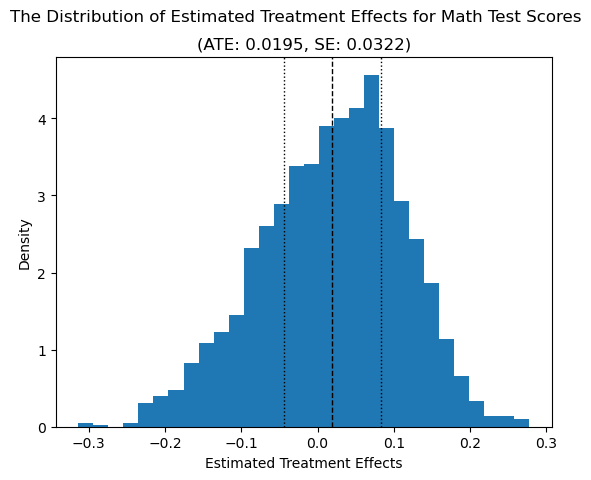

In [27]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_math, bins=30, density=True)
plt.axvline(rcf_math.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_math.ate_+1.96*rcf_math.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_math.ate_-1.96*rcf_math.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Math Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_math.ate_[0], rcf_math.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

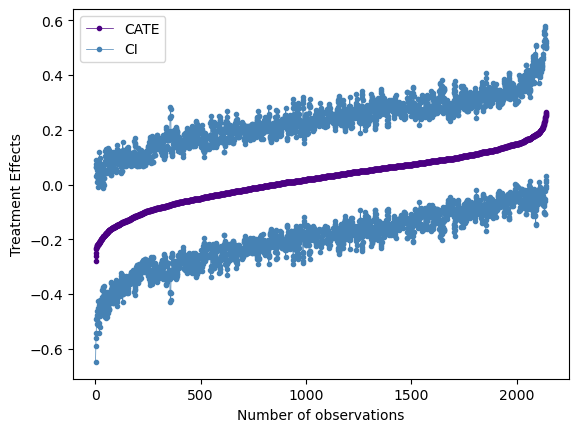

In [28]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

In [29]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_math2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_math.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
std_math2015,0.224835
stu_SLR_std2015,0.163553
stu_SCR_std2015,0.162705
stu_byear2015,0.064638
stu_female2015,0.054131
stu_home_rtime_a302015,0.044116
stu_edu_r4chi2015,0.031426
stu_rfrd_rdiscuss2015,0.030778
hh_lb2015,0.028553
stu_rfrd_rtogether2015,0.027382


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

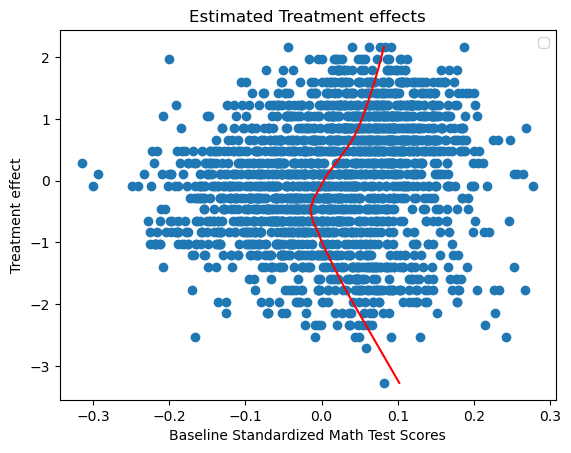

In [30]:
lowess = sm.nonparametric.lowess(df_math['effects'], df_math['std_math2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_math['effects'], df_math['std_math2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Standardized Math Test Scores")
plt.ylabel("Treatment effect")

#### 3.3 For Language Test Scores

In [31]:
# define the variables
y = df_chi['std_chi2016'] 

z = df_chi['treat2015'] # treat assignment

x = df_chi[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_chi2015']] 

In [32]:
# Instantiate the Causal Forest
rcf_chi = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_chi.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [33]:
# Calculate the predicted effects (for each observation)
insamplefx_chi = rcf_chi.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_chi, ub_chi = rcf_chi.effect_interval(x, alpha=0.05)

In [34]:
# Merge CATEs into the original dataframe
df_chi['effects'] = insamplefx_chi
df_chi['effects_lb'] = lb_chi
df_chi['effects_ub'] = ub_chi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_chi[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.501576,-0.756864,-0.246288
1,-0.498842,-0.870356,-0.127327
2,-0.475998,-0.921036,-0.030959
3,-0.435567,-0.799271,-0.071863
4,-0.417237,-0.685042,-0.149432
...,...,...,...
2127,0.242873,-0.085676,0.571422
2128,0.243296,-0.058409,0.545000
2129,0.252067,0.003751,0.500383
2130,0.266920,-0.177870,0.711709


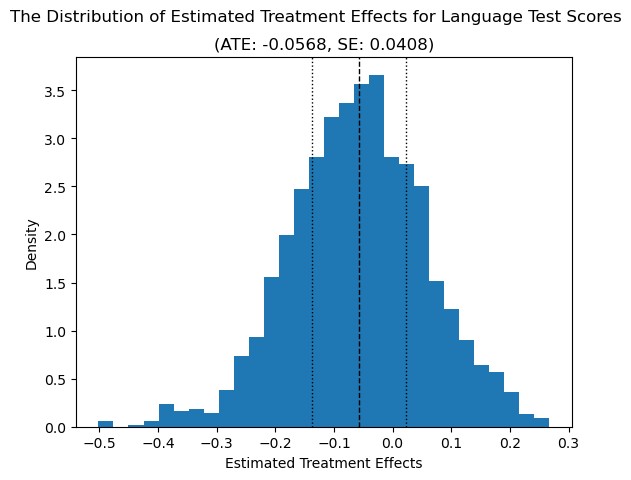

In [36]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_chi, bins=30, density=True)
plt.axvline(rcf_chi.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_chi.ate_+1.96*rcf_chi.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_chi.ate_-1.96*rcf_chi.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Language Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_chi.ate_[0], rcf_chi.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

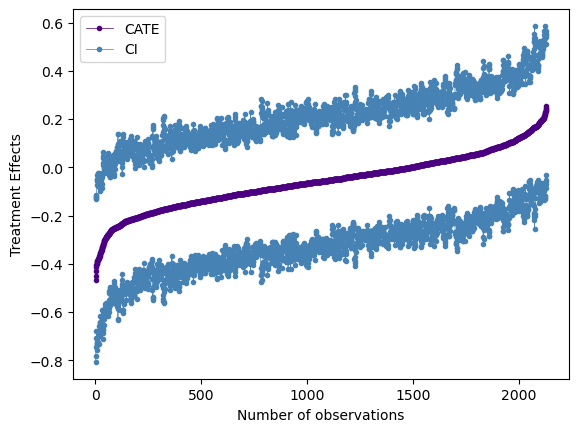

In [37]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

In [38]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_chi2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_chi.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
std_chi2015,0.199706
stu_SLR_std2015,0.162845
stu_SCR_std2015,0.162448
stu_byear2015,0.064036
stu_female2015,0.047170
stu_home_rtime_a302015,0.041643
stu_rfrd_rborrow2015,0.038482
hh_lb2015,0.038079
stu_rfrd_rdiscuss2015,0.034348
stu_rfrd_rtogether2015,0.029483


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

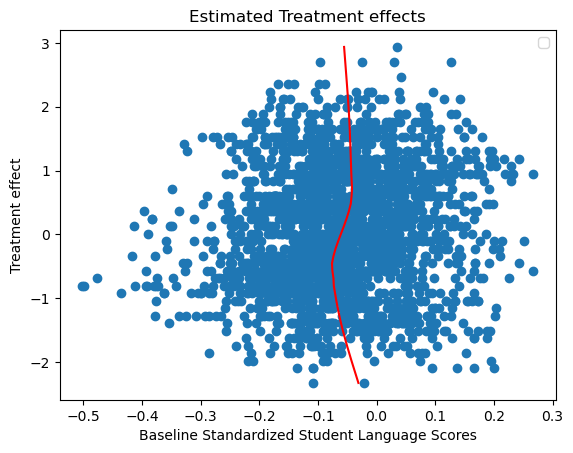

In [39]:
lowess = sm.nonparametric.lowess(df_chi['effects'], df_chi['std_chi2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_chi['effects'], df_chi['std_chi2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Standardized Student Language Scores")
plt.ylabel("Treatment effect")

## Part III - Discuss and Conclusion

The main goal of the project is to assess heterogeneity in a randomized control trial using advanced machine learning tools. In contrast to the conventional approach of using linear regression with interaction terms or conducting separate regression in each subgroups, the utilization of newly developed machine learning tools, such as the random causal forest employed in this study, offers several advantages. These tools provide increased flexibility and predictive power, allowing for a data-driven approach to identify important features and generate more accurate confidence intervals.

To achieve that, I first build up the random causal forest and use it to predict treatment effects for each indiviudal observation. I then plot the distribution of these effects predictions as a rough diagnose for heterogeneous treatment effects. I also examine the importance of different features and investigate whether the most important feature identified displays any interesting patterns of heterogeneity in relation to the estimated treatment effects. 

The findings suggest that almost all the predicted treatment effects are not statistically different from zero. Moreover, no notable patterns of heterogeneity were observed. However, it is worth noting that the baseline student like reading scores and the baseline subject (math and language) test scores appear to be the features that contribute most to the predictions. 